In [1]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib import rc
import astropy.units as u
from astropy import constants as const
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings
import time

from scipy.stats.kde import gaussian_kde
from numpy import linspace

import h5py as h5 


In [2]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
#     matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [4]:
hobbs_pathData        = os.environ['SCRATCH']+f'/supernova_remnant_merger_rates/hobbs_2e7_combined.h5'
mm_pathData        = os.environ['SCRATCH'] + f"/supernova_remnant_merger_rates/mm20_2e7_combined.h5"

In [5]:
fdata = h5.File(hobbs_pathData, 'r')

SEED = fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
unique, counts = np.unique(SEED, return_counts=True)
print(len(SEED))
print(len(unique))

fdata.close()

20000064
20000064


In [6]:
fdata = h5.File(mm_pathData, 'r')

SEED = fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
unique, counts = np.unique(SEED, return_counts=True)
print(len(SEED))
print(len(unique))

fdata.close()

20000064
20000064


# Investigate properties of mergers

To get the eccentricity-period distribution of BNSs, we set dco_type='bns' above, and will select the set of DCOs from the H5 file whose Merges_Hubble_Time==True, Stellar_Type(1)'+ 'Stellar_Type(2)==26.

In [7]:
def mask_type(data, st_type1, st_type2, dco_type='BNS', merge=None):
    masked_data = data
    
    if merge is not None:
        mask_hubble = (merge==True)
        masked_data = masked_data[mask_hubble]
        st_type1 = st_type1[mask_hubble]
        st_type2 = st_type2[mask_hubble]
        
    if dco_type=='BBH':
        st_type_sum = 28
    if dco_type=='BNS':
        st_type_sum = 26
    if dco_type=='BHNS':
        st_type_sum = 27
    if dco_type=='all':
        return masked_data
    
    mask = (st_type1 + st_type2==st_type_sum)
    return masked_data[mask]

In [8]:
# sma in AU
# m1 in M_sun 
# m2 in M_sun
# period in yr

def sma_to_period(sma, m1, m2):
    sma = sma*u.au
    m1 = m1*const.M_sun
    m2 = m2*const.M_sun
    
    return 2*np.pi*np.sqrt((sma**3)/(const.G*(m1+m2))).to(u.yr).value

In [9]:
hobbs_fdata = h5.File(hobbs_pathData, 'r')
hobbs_merge = hobbs_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

hobbs_m1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
hobbs_m2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

hobbs_type1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
hobbs_type2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

hobbs_ecc_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
hobbs_sma_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
hobbs_dco_seed = hobbs_fdata['BSE_Double_Compact_Objects']["SEED"][()]

hobbs_unbound_ALL = hobbs_fdata['BSE_Supernovae']["Unbound"][()]
hobbs_kicks_ALL = hobbs_fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][()]
hobbs_sn_stellartype = hobbs_fdata['BSE_Supernovae']["Stellar_Type(SN)"][()]
hobbs_sn_orbital_v = hobbs_fdata['BSE_Supernovae']["Orb_Velocity<SN"][()]

hobbs_sn_sma = hobbs_fdata['BSE_Supernovae']["SemiMajorAxis<SN"][()]
hobbs_sn_mass_sn = hobbs_fdata['BSE_Supernovae']['Mass(SN)'][()]
hobbs_sn_mass_cp = hobbs_fdata['BSE_Supernovae']['Mass(CP)'][()]

hobbs_sn_seed = hobbs_fdata['BSE_Supernovae']["SEED"][()]

hobbs_fdata.close()

In [10]:
mm_fdata = h5.File(mm_pathData, 'r')
mm_merge = mm_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

mm_m1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
mm_m2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

mm_type1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
mm_type2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

mm_ecc_ALL = mm_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
mm_sma_ALL = mm_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
mm_dco_seed = mm_fdata['BSE_Double_Compact_Objects']["SEED"][()]

mm_unbound_ALL = mm_fdata['BSE_Supernovae']["Unbound"][()]
mm_kicks_ALL = mm_fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][()]
mm_sn_stellartype = mm_fdata['BSE_Supernovae']["Stellar_Type(SN)"][()]
mm_sn_orbital_v = mm_fdata['BSE_Supernovae']["Orb_Velocity<SN"][()]

mm_sn_sma = mm_fdata['BSE_Supernovae']["SemiMajorAxis<SN"][()]
mm_sn_mass_sn = mm_fdata['BSE_Supernovae']['Mass(SN)'][()]
mm_sn_mass_cp = mm_fdata['BSE_Supernovae']['Mass(CP)'][()]

print(mm_fdata['BSE_Supernovae']['Mass(SN)'].attrs['units'])
print(mm_fdata['BSE_Supernovae']["SemiMajorAxis<SN"].attrs['units'])

mm_sn_seed = mm_fdata['BSE_Supernovae']["SEED"][()]

mm_fdata.close()


b'Msol'
b'Rsol'


## See the Kick distribution of unbound objects

In [11]:
hobbs_unbound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_ns_kicks = hobbs_kicks_ALL[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_ns_kicks = mm_kicks_ALL[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

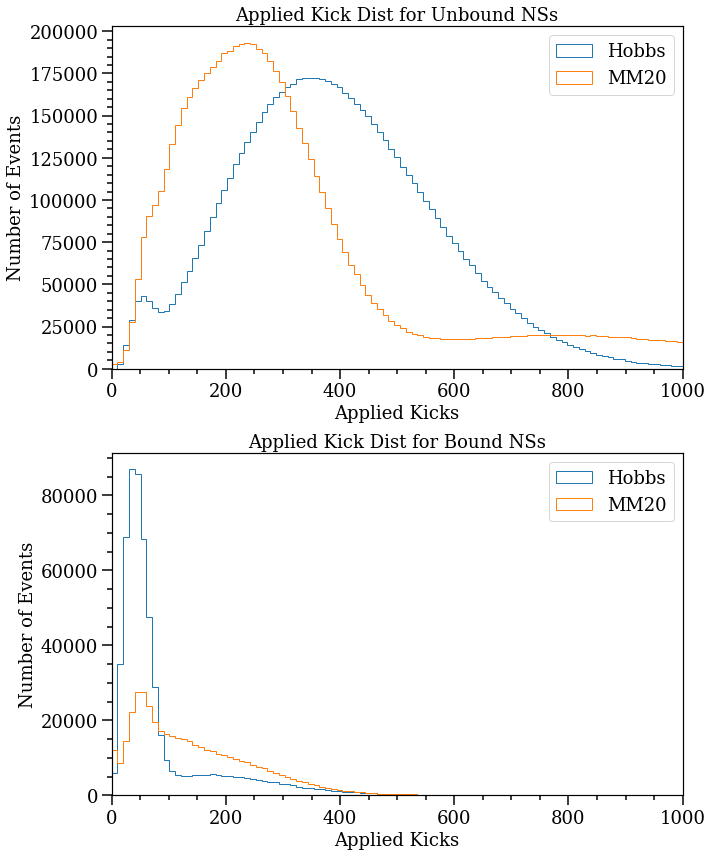

In [116]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,12)) 

layoutAxes(ax=ax1, nameX='Applied Kicks',\
           nameY='Number of Events')

layoutAxes(ax=ax2, nameX='Applied Kicks',\
           nameY='Number of Events')


bins = np.linspace(0, 1000, 100)

ax1.hist(hobbs_unbound_ns_kicks, bins=bins, histtype='step', density=False, label="Hobbs")
ax1.hist(mm_unbound_ns_kicks, bins=bins, histtype='step',  density=False, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Applied Kick Dist for Unbound NSs", fontsize=fm)
ax1.set_xlim(0, 1000)

ax2.hist(hobbs_bound_ns_kicks, bins=bins, histtype='step', density=False, label="Hobbs")
ax2.hist(mm_bound_ns_kicks, bins=bins, histtype='step',  density=False, label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Applied Kick Dist for Bound NSs", fontsize=fm)
ax2.set_xlim(0, 1000)
plt.tight_layout()
plt.show()

In [19]:
hobbs_unbound_orbital_v = hobbs_sn_orbital_v[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 1))]
mm_unbound_orbital_v = mm_sn_orbital_v[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 1))]

hobbs_bound_orbital_v = hobbs_sn_orbital_v[((hobbs_sn_stellartype ==13)*(hobbs_unbound_ALL == 0))]
mm_bound_orbital_v = mm_sn_orbital_v[((mm_sn_stellartype ==13)*(mm_unbound_ALL == 0))]

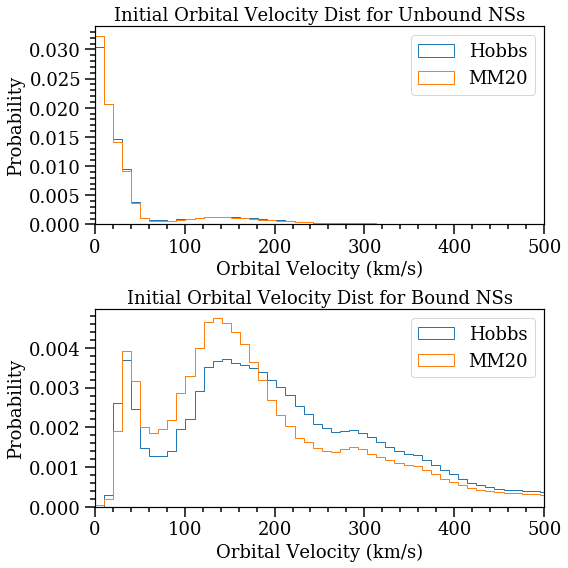

In [119]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Orbital Velocity (km/s)',\
           nameY='Probability')
layoutAxes(ax=ax2, nameX='Orbital Velocity (km/s)',\
           nameY='Probability')

bins = np.linspace(0, 1000, 100)

ax1.hist(hobbs_unbound_orbital_v, bins=bins, histtype='step', density=True, label="Hobbs")
ax1.hist(mm_unbound_orbital_v, bins=bins, histtype='step',  density=True, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Initial Orbital Velocity Dist for Unbound NSs", fontsize=fm)
ax1.set_xlim(0, 500)

ax2.hist(hobbs_bound_orbital_v, bins=bins, histtype='step', density=True, label="Hobbs")
ax2.hist(mm_bound_orbital_v, bins=bins, histtype='step',  density=True, label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Initial Orbital Velocity Dist for Bound NSs", fontsize=fm)
ax2.set_xlim(0, 500)

plt.tight_layout()
plt.show()

## What percentage of Supernovae keep (future) BNS systems intact in the two cases?

In [24]:
mm_future_bns_seeds_dco = mask_type(mm_dco_seed, mm_type1_ALL, mm_type2_ALL, dco_type='BNS', merge=mm_merge)
print(mm_future_bns_seeds_dco)
print(len(mm_future_bns_seeds_dco))

mm_future_bns_seeds_sn_mask = np.in1d(mm_sn_seed, mm_future_bns_seeds_dco)
mm_future_bns_seeds_sn = mm_sn_seed[mm_future_bns_seeds_sn_mask]

print(mm_future_bns_seeds_sn)
print(len(mm_future_bns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18667016 18681776 18689693 ... 24646600 24654812 24673454]
2014
[18667016 18667016 18681776 ... 24654812 24673454 24673454]
4028


In [25]:
hobbs_future_bns_seeds_dco = mask_type(hobbs_dco_seed, hobbs_type1_ALL, hobbs_type2_ALL, dco_type='BNS', merge=hobbs_merge)
print(hobbs_future_bns_seeds_dco)
print(len(hobbs_future_bns_seeds_dco))

hobbs_future_bns_seeds_sn_mask = np.in1d(hobbs_sn_seed, hobbs_future_bns_seeds_dco)
hobbs_future_bns_seeds_sn = hobbs_sn_seed[hobbs_future_bns_seeds_sn_mask]

print(hobbs_future_bns_seeds_sn)
print(len(hobbs_future_bns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18665943 18667016 18674379 ... 24673454 24680667 24684340]
3344
[18665943 18665943 18667016 ... 24680667 24684340 24684340]
6688


In [26]:
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)]
mm_kicks_bns_bound = mm_kicks_ALL[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bns_seeds_sn_mask]

mm_bns_percentage = (len(mm_kicks_bns_bound)/len(mm_kicks_ns)*100)
print(f"{mm_bns_percentage:.2f}% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BNS")

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
hobbs_kicks_bns_bound = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bns_seeds_sn_mask]

hobbs_bns_percentage = (len(hobbs_kicks_bns_bound)/len(hobbs_kicks_ns)*100)

print(f"{hobbs_bns_percentage:.2f}% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BNS")


0.05% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BNS
0.08% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BNS


In [118]:
print(sum((mm_sn_stellartype ==13) * (mm_unbound_ALL == 1)))
print(sum((mm_sn_stellartype ==13)))
print(sum((hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 1)))
print(sum((hobbs_sn_stellartype ==13)))

7195459
7638084
7385149
7961537


## What percentage of Supernovae keep (future) BHNS systems intact in the two cases?

In [27]:
mm_future_bhns_seeds_dco = mask_type(mm_dco_seed, mm_type1_ALL, mm_type2_ALL, dco_type='BHNS', merge=mm_merge)
print(mm_future_bhns_seeds_dco)
print(len(mm_future_bhns_seeds_dco))

mm_future_bhns_seeds_sn_mask = np.in1d(mm_sn_seed, mm_future_bhns_seeds_dco)
mm_future_bhns_seeds_sn = mm_sn_seed[mm_future_bhns_seeds_sn_mask]

print(mm_future_bhns_seeds_sn)
print(len(mm_future_bhns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18661387 18662094 18662992 ... 24681463 24682191 24685182]
11061
[18661387 18661387 18662094 ... 24682191 24685182 24685182]
22122


In [28]:
hobbs_future_bhns_seeds_dco = mask_type(hobbs_dco_seed, hobbs_type1_ALL, hobbs_type2_ALL, dco_type='BHNS', merge=hobbs_merge)
print(hobbs_future_bhns_seeds_dco)
print(len(hobbs_future_bhns_seeds_dco))

hobbs_future_bhns_seeds_sn_mask = np.in1d(hobbs_sn_seed, hobbs_future_bhns_seeds_dco)
hobbs_future_bhns_seeds_sn = hobbs_sn_seed[hobbs_future_bhns_seeds_sn_mask]

print(hobbs_future_bhns_seeds_sn)
print(len(hobbs_future_bhns_seeds_sn)) # should be double the number of dcos because 2 supernovae per binary system

[18661287 18665543 18666364 ... 24671380 24673753 24680230]
6622
[18661287 18661287 18665543 ... 24673753 24680230 24680230]
13244


In [29]:
mm_kicks_ns = mm_kicks_ALL[(mm_sn_stellartype ==13)]
mm_kicks_bhns_bound = mm_kicks_ALL[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bhns_seeds_sn_mask]

mm_bhns_percentage = (len(mm_kicks_bhns_bound)/len(mm_kicks_ns)*100)
print(f"{mm_bhns_percentage:.2f}% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BHNS")

hobbs_kicks_ns = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13)]
hobbs_kicks_bhns_bound = hobbs_kicks_ALL[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bhns_seeds_sn_mask]

hobbs_bhns_percentage = (len(hobbs_kicks_bhns_bound)/len(hobbs_kicks_ns)*100)

print(f"{hobbs_bhns_percentage:.2f}% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BHNS")


0.14% of MM20 SNe that produce NSs leave the binary intact, where the final system is a BHNS
0.08% of Hobbs SNe that produce NSs leave the binary intact, where the final system is a BHNS


I don't get it. Why should the number of BNS and BHNS systems left intact by Hobbs be the same? Shouldn't more BHNS systems survive due to higher required kicks to disrupt?

# What is the initial Energy Distribution of Binaries left intact?

## Gravitational Energy Dist

Energy = $\frac{-GM_1 M_2}{2a}$, where $a$ is the semi-major axis.

In [52]:
mm_masks_bns = ((mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bns_seeds_sn_mask)
mm_bns_bound_init_sma = mm_sn_sma[mm_masks_bns]
mm_bns_m1 = mm_sn_mass_sn[mm_masks_bns]
mm_bns_m2 = mm_sn_mass_cp[mm_masks_bns]
mm_bns_bound_init_energy = (const.G * mm_bns_m1*u.M_sun * mm_bns_m2*u.M_sun) / (2*mm_bns_bound_init_sma*u.R_sun)
mm_bns_bound_init_energy = mm_bns_bound_init_energy.to(u.Joule).value

hobbs_masks_bns = ((hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bns_seeds_sn_mask)
hobbs_bns_bound_init_sma = hobbs_sn_sma[hobbs_masks_bns]
hobbs_bns_m1 = hobbs_sn_mass_sn[hobbs_masks_bns]
hobbs_bns_m2 = hobbs_sn_mass_cp[hobbs_masks_bns]
hobbs_bns_bound_init_energy = (const.G * hobbs_bns_m1*u.M_sun * hobbs_bns_m2*u.M_sun) / (2*hobbs_bns_bound_init_sma*u.R_sun)
hobbs_bns_bound_init_energy = hobbs_bns_bound_init_energy.to(u.Joule).value

mm_masks_bhns = ((mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bhns_seeds_sn_mask)
mm_bhns_bound_init_sma = mm_sn_sma[mm_masks_bhns]
mm_bhns_m1 = mm_sn_mass_sn[mm_masks_bhns]
mm_bhns_m2 = mm_sn_mass_cp[mm_masks_bhns]
mm_bhns_bound_init_energy = (const.G * mm_bhns_m1*u.M_sun * mm_bhns_m2*u.M_sun) / (2*mm_bhns_bound_init_sma*u.R_sun)
mm_bhns_bound_init_energy = mm_bhns_bound_init_energy.to(u.Joule).value

hobbs_masks_bhns = ((hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bhns_seeds_sn_mask)
hobbs_bhns_bound_init_sma = hobbs_sn_sma[hobbs_masks_bhns]
hobbs_bhns_m1 = hobbs_sn_mass_sn[hobbs_masks_bhns]
hobbs_bhns_m2 = hobbs_sn_mass_cp[hobbs_masks_bhns]
hobbs_bhns_bound_init_energy = (const.G * hobbs_bhns_m1*u.M_sun * hobbs_bhns_m2*u.M_sun) / (2*hobbs_bhns_bound_init_sma*u.R_sun)
hobbs_bhns_bound_init_energy = hobbs_bhns_bound_init_energy.to(u.Joule).value



mm_masks_unbound_ns = (mm_sn_stellartype ==13) * (mm_unbound_ALL == 1)
mm_kicks_unbound = mm_kicks_ALL[mm_masks_unbound_ns]
mm_unbound_init_sma = mm_sn_sma[mm_masks_unbound_ns]
mm_m1 = mm_sn_mass_sn[mm_masks_unbound_ns ]
mm_m2 = mm_sn_mass_cp[mm_masks_unbound_ns]
mm_unbound_init_energy = (const.G * mm_m1*u.M_sun * mm_m2*u.M_sun) / (2*mm_unbound_init_sma*u.R_sun)
mm_unbound_init_energy = mm_unbound_init_energy.to(u.Joule).value

hobbs_masks_unbound_ns = (hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 1)
hobbs_kicks_unbound = hobbs_kicks_ALL[hobbs_masks_unbound_ns]
hobbs_unbound_init_sma = hobbs_sn_sma[hobbs_masks_unbound_ns]
hobbs_m1 = hobbs_sn_mass_sn[hobbs_masks_unbound_ns]
hobbs_m2 = hobbs_sn_mass_cp[hobbs_masks_unbound_ns]
hobbs_unbound_init_energy = (const.G * hobbs_m1*u.M_sun * hobbs_m2*u.M_sun) / (2*hobbs_unbound_init_sma*u.R_sun)
hobbs_unbound_init_energy = hobbs_unbound_init_energy.to(u.Joule).value


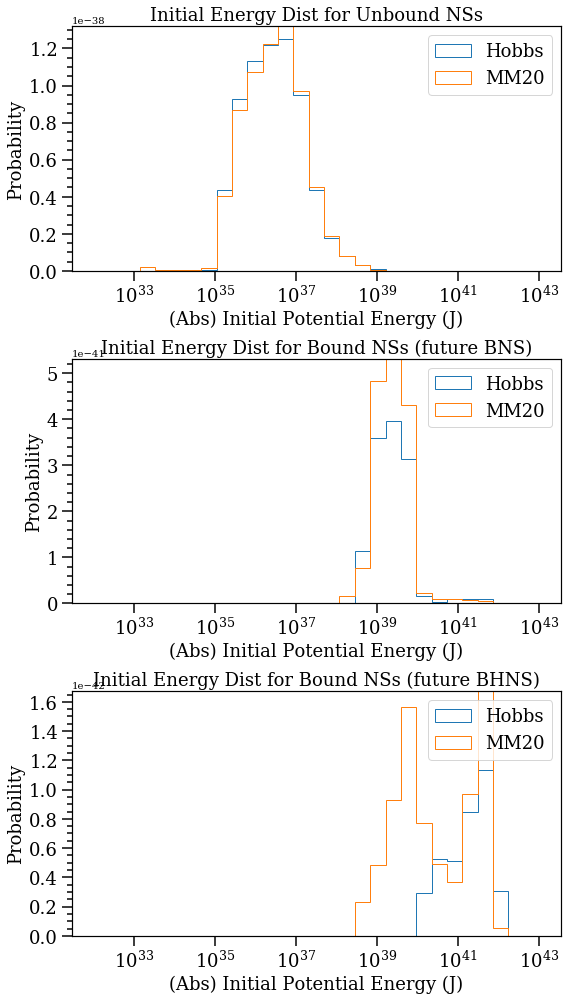

In [60]:
f, (ax1, ax2, ax3)= plt.subplots(3, 1,  figsize=(8,14)) 

layoutAxes(ax=ax1, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')
layoutAxes(ax=ax2, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')
layoutAxes(ax=ax3, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')

bins = np.logspace(32, 43, 30)

ax1.hist(hobbs_unbound_init_energy, bins=bins, histtype='step', density=True, label="Hobbs")
ax1.hist(mm_unbound_init_energy, bins=bins, histtype='step',  density=True, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Initial Energy Dist for Unbound NSs", fontsize=fm)
ax1.set_xscale('log')

ax2.hist(hobbs_bns_bound_init_energy, bins=bins, histtype='step', density=True, label="Hobbs")
ax2.hist(mm_bns_bound_init_energy, bins=bins, histtype='step',  density=True, label="MM20")
ax2.legend(fontsize=fm)
ax2.set_title("Initial Energy Dist for Bound NSs (future BNS)", fontsize=fm)
ax2.set_xscale('log')

ax3.hist(hobbs_bhns_bound_init_energy, bins=bins, histtype='step', density=True, label="Hobbs")
ax3.hist(mm_bhns_bound_init_energy, bins=bins, histtype='step',  density=True, label="MM20")
ax3.legend(fontsize=fm)
ax3.set_title("Initial Energy Dist for Bound NSs (future BHNS)", fontsize=fm)
ax3.set_xscale('log')

plt.tight_layout()
plt.show()

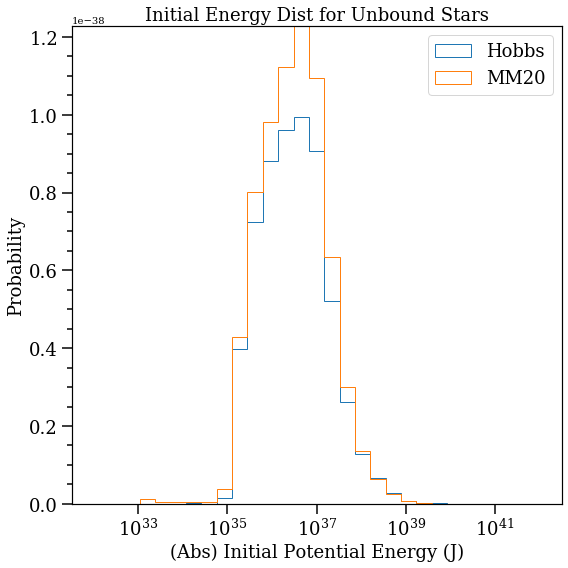

In [58]:
f, (ax1)= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='(Abs) Initial Potential Energy (J)',\
           nameY='Probability')

bins = np.logspace(32, 42, 30)

ax1.hist(hobbs_unbound_init_energy_all, bins=bins, histtype='step', density=True, label="Hobbs")
ax1.hist(mm_unbound_init_energy_all, bins=bins, histtype='step',  density=True, label="MM20")
ax1.legend(fontsize=fm)
ax1.set_title("Initial Energy Dist for Unbound Stars", fontsize=fm)
ax1.set_xscale('log')


plt.tight_layout()
plt.show()

## Orbital Velocity vs Kick

In [ ]:
mm_unbound_init_vel = mm_sn_orbital_v[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 1)]
hobbsunbound_init_vel = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 1)]

f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Velocity')

plt.title("Unbound NS", fontsize=fl)

plt.scatter(hobbs_kicks_bhns_bound, hobbs_bhns_bound_init_vel, s=ms, label='Hobbs')
plt.scatter(mm_kicks_bhns_bound, mm_bhns_bound_init_vel, s=ms, label='MM20')


x = np.linspace(0, 2000, 10)
plt.plot(x, x, 'r--', alpha=0.7)

plt.xlim(0, 2000)
plt.ylim(0, 2000)

plt.legend(fontsize=fm)
plt.show()

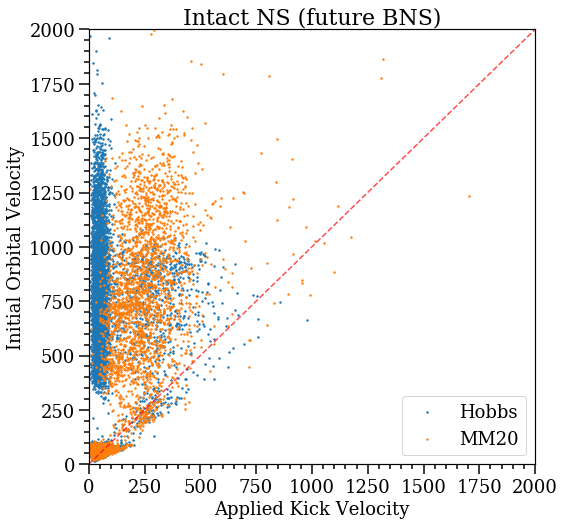

In [63]:
mm_bns_bound_init_vel = mm_sn_orbital_v[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bns_seeds_sn_mask]
hobbs_bns_bound_init_vel = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bns_seeds_sn_mask]

ms = 2

f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Velocity')

plt.title("Intact NS (future BNS)", fontsize=fl)

plt.scatter(hobbs_kicks_bns_bound, hobbs_bns_bound_init_vel, s=ms, label='Hobbs')
plt.scatter(mm_kicks_bns_bound, mm_bns_bound_init_vel, s=ms, label='MM20')


x = np.linspace(0, 2000, 10)
plt.plot(x, x, 'r--', alpha=0.7)

plt.xlim(0, 2000)
plt.ylim(0, 2000)

plt.legend(fontsize=fm)
plt.show()



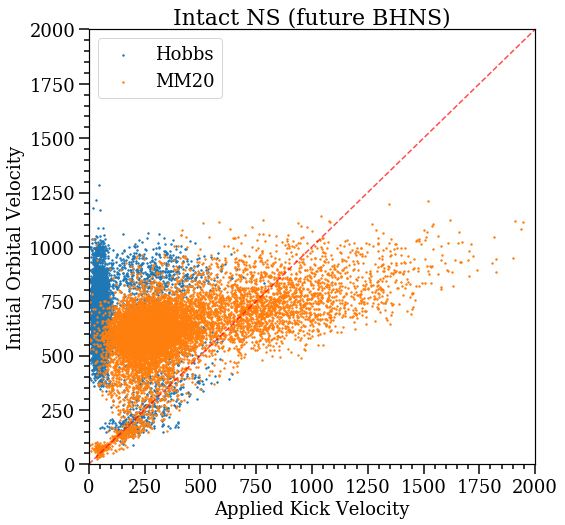

In [62]:
mm_bhns_bound_init_vel = mm_sn_orbital_v[(mm_sn_stellartype ==13) * (mm_unbound_ALL == 0) * mm_future_bhns_seeds_sn_mask]
hobbs_bhns_bound_init_vel = hobbs_sn_orbital_v[(hobbs_sn_stellartype ==13) * (hobbs_unbound_ALL == 0) * hobbs_future_bhns_seeds_sn_mask]

ms=2

f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Velocity')

plt.title("Intact NS (future BHNS)", fontsize=fl)

plt.scatter(hobbs_kicks_bhns_bound, hobbs_bhns_bound_init_vel, s=ms, label='Hobbs')
plt.scatter(mm_kicks_bhns_bound, mm_bhns_bound_init_vel, s=ms, label='MM20')


x = np.linspace(0, 2000, 10)
plt.plot(x, x, 'r--', alpha=0.7)

plt.xlim(0, 2000)
plt.ylim(0, 2000)

plt.legend(fontsize=fm)
plt.show()




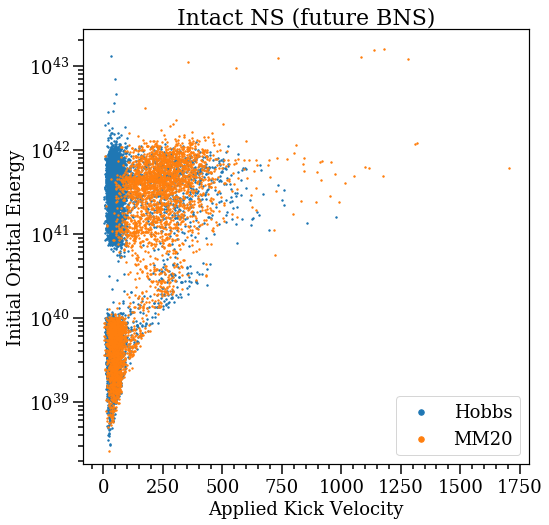

In [64]:
ms = 2

f, ax1= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Energy')



ax1.set_title("Intact NS (future BNS)", fontsize=fl)

ax1.scatter(hobbs_kicks_bns_bound, hobbs_bns_bound_init_energy, s=ms, label='Hobbs')
ax1.scatter(mm_kicks_bns_bound, mm_bns_bound_init_energy, s=ms, label='MM20')


plt.semilogy()

lgnd = plt.legend(scatterpoints=1, fontsize=fm)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()




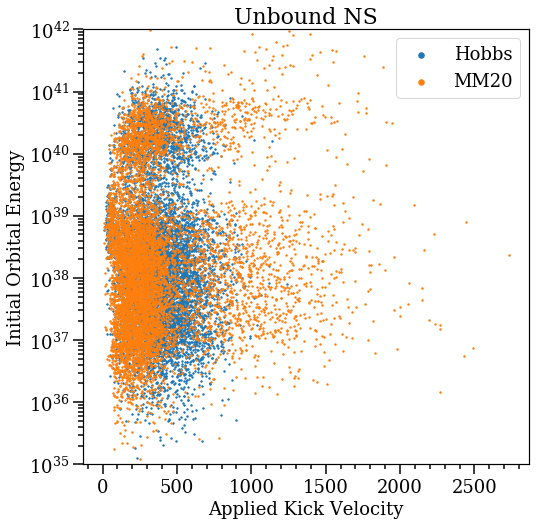

In [69]:
ms = 2

f, ax1= plt.subplots(1, 1,  figsize=(8,8)) 

layoutAxes(ax=ax1, nameX='Applied Kick Velocity',\
           nameY='Initial Orbital Energy')

ax1.set_title("Unbound NS", fontsize=fl)
N = 10000
ax1.scatter(hobbs_kicks_unbound[:N], hobbs_unbound_init_energy[:N], s=ms, label='Hobbs')
ax1.scatter(mm_kicks_unbound[:N], mm_unbound_init_energy[:N], s=ms, label='MM20')

plt.semilogy()
plt.ylim(1e35, 1e42)


lgnd = plt.legend(scatterpoints=1, fontsize=fm)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

plt.show()




In [153]:
threshold = 80
mm_tot = len(mm_kicks_unbound[::10])
mm_below_t = sum(mm_kicks_unbound < threshold)

In [154]:
hobbs_tot = len(hobbs_kicks_unbound[::10])
hobbs_below_t = sum(hobbs_kicks_unbound < threshold)

In [155]:
print(f"MM20 kicks out {100* (mm_below_t/hobbs_below_t - 1.0):.2f}% more NS below {threshold} km/s.")
print(f"For reference, MM20 produces {100* (1.0 - 15.04/24.67):.2f}% fewer NS mergers.")

MM20 kicks out 75.45% more NS below 80 km/s.
For reference, MM20 produces 39.04% fewer NS mergers.


In [120]:
mm_sampled = mm_kicks_unbound[::10]
vels = np.linspace(0, 2000, 40)
mm_cdf = np.zeros(len(vels))

for i in range(len(vels)):
    mm_cdf[i] = sum(mm_sampled < vels[i])

In [121]:
for i in range(len(vels)):
    print(f"{100*mm_cdf[i]/len(mm_sampled):.2f}% of MM20 kicks (unbound) are below {vels[i]:.0f} km/s")

0.00% of MM20 kicks (unbound) are below 0 km/s
1.46% of MM20 kicks (unbound) are below 51 km/s
8.43% of MM20 kicks (unbound) are below 103 km/s
19.30% of MM20 kicks (unbound) are below 154 km/s
31.97% of MM20 kicks (unbound) are below 205 km/s
45.50% of MM20 kicks (unbound) are below 256 km/s
58.14% of MM20 kicks (unbound) are below 308 km/s
67.93% of MM20 kicks (unbound) are below 359 km/s
74.27% of MM20 kicks (unbound) are below 410 km/s
77.91% of MM20 kicks (unbound) are below 462 km/s
80.02% of MM20 kicks (unbound) are below 513 km/s
81.47% of MM20 kicks (unbound) are below 564 km/s
82.71% of MM20 kicks (unbound) are below 615 km/s
83.96% of MM20 kicks (unbound) are below 667 km/s
85.31% of MM20 kicks (unbound) are below 718 km/s
86.70% of MM20 kicks (unbound) are below 769 km/s
88.09% of MM20 kicks (unbound) are below 821 km/s
89.46% of MM20 kicks (unbound) are below 872 km/s
90.75% of MM20 kicks (unbound) are below 923 km/s
91.95% of MM20 kicks (unbound) are below 974 km/s
93.05%

In [122]:
for i in range(len(vels)):
    print(f"{mm_cdf[i]:.0f} MM20 kicks (unbound) are below {vels[i]:.0f} km/s")

0 MM20 kicks (unbound) are below 0 km/s
10471 MM20 kicks (unbound) are below 51 km/s
60677 MM20 kicks (unbound) are below 103 km/s
138891 MM20 kicks (unbound) are below 154 km/s
230073 MM20 kicks (unbound) are below 205 km/s
327405 MM20 kicks (unbound) are below 256 km/s
418350 MM20 kicks (unbound) are below 308 km/s
488814 MM20 kicks (unbound) are below 359 km/s
534375 MM20 kicks (unbound) are below 410 km/s
560618 MM20 kicks (unbound) are below 462 km/s
575795 MM20 kicks (unbound) are below 513 km/s
586209 MM20 kicks (unbound) are below 564 km/s
595137 MM20 kicks (unbound) are below 615 km/s
604130 MM20 kicks (unbound) are below 667 km/s
613878 MM20 kicks (unbound) are below 718 km/s
623860 MM20 kicks (unbound) are below 769 km/s
633856 MM20 kicks (unbound) are below 821 km/s
643695 MM20 kicks (unbound) are below 872 km/s
653005 MM20 kicks (unbound) are below 923 km/s
661604 MM20 kicks (unbound) are below 974 km/s
669510 MM20 kicks (unbound) are below 1026 km/s
676625 MM20 kicks (unb

In [123]:
hobbs_sampled = hobbs_kicks_unbound[::10]
vels = np.linspace(0, 2000, 40)
hobbs_cdf = np.zeros(len(vels))

for i in range(len(vels)):
    hobbs_cdf[i] = sum(hobbs_sampled < vels[i])

In [124]:
for i in range(len(vels)):
    print(f"{100*hobbs_cdf[i]/len(hobbs_sampled):.2f}% of Hobbs kicks (unbound) are below {vels[i]:.0f} km/s")

0.00% of Hobbs kicks (unbound) are below 0 km/s
1.22% of Hobbs kicks (unbound) are below 51 km/s
3.81% of Hobbs kicks (unbound) are below 103 km/s
7.46% of Hobbs kicks (unbound) are below 154 km/s
13.75% of Hobbs kicks (unbound) are below 205 km/s
22.66% of Hobbs kicks (unbound) are below 256 km/s
33.50% of Hobbs kicks (unbound) are below 308 km/s
45.17% of Hobbs kicks (unbound) are below 359 km/s
56.79% of Hobbs kicks (unbound) are below 410 km/s
67.39% of Hobbs kicks (unbound) are below 462 km/s
76.48% of Hobbs kicks (unbound) are below 513 km/s
83.73% of Hobbs kicks (unbound) are below 564 km/s
89.23% of Hobbs kicks (unbound) are below 615 km/s
93.13% of Hobbs kicks (unbound) are below 667 km/s
95.81% of Hobbs kicks (unbound) are below 718 km/s
97.53% of Hobbs kicks (unbound) are below 769 km/s
98.60% of Hobbs kicks (unbound) are below 821 km/s
99.25% of Hobbs kicks (unbound) are below 872 km/s
99.61% of Hobbs kicks (unbound) are below 923 km/s
99.80% of Hobbs kicks (unbound) are be

In [125]:
for i in range(len(vels)):
    print(f"{hobbs_cdf[i]:.0f} Hobbs kicks (unbound) are below {vels[i]:.0f} km/s")

0 Hobbs kicks (unbound) are below 0 km/s
9026 Hobbs kicks (unbound) are below 51 km/s
28139 Hobbs kicks (unbound) are below 103 km/s
55094 Hobbs kicks (unbound) are below 154 km/s
101573 Hobbs kicks (unbound) are below 205 km/s
167319 Hobbs kicks (unbound) are below 256 km/s
247393 Hobbs kicks (unbound) are below 308 km/s
333624 Hobbs kicks (unbound) are below 359 km/s
419409 Hobbs kicks (unbound) are below 410 km/s
497659 Hobbs kicks (unbound) are below 462 km/s
564839 Hobbs kicks (unbound) are below 513 km/s
618391 Hobbs kicks (unbound) are below 564 km/s
658993 Hobbs kicks (unbound) are below 615 km/s
687766 Hobbs kicks (unbound) are below 667 km/s
707538 Hobbs kicks (unbound) are below 718 km/s
720276 Hobbs kicks (unbound) are below 769 km/s
728140 Hobbs kicks (unbound) are below 821 km/s
732944 Hobbs kicks (unbound) are below 872 km/s
735630 Hobbs kicks (unbound) are below 923 km/s
737070 Hobbs kicks (unbound) are below 974 km/s
737788 Hobbs kicks (unbound) are below 1026 km/s
738

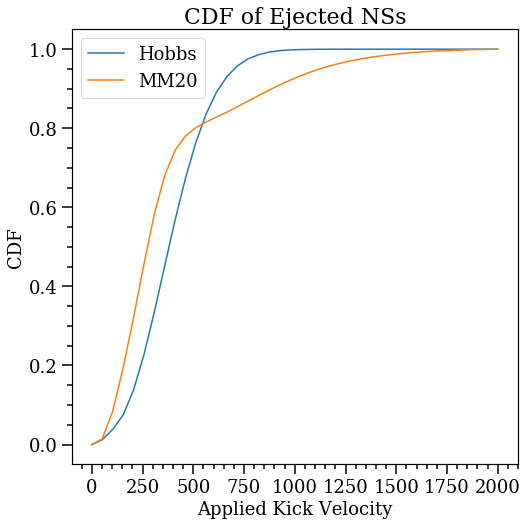

In [159]:
f, ax1= plt.subplots(1, 1,  figsize=(8,8)) 
hobbs_cdf_norm = hobbs_cdf/max(hobbs_cdf)

mm_cdf_norm = mm_cdf/max(mm_cdf)

plt.plot(vels, hobbs_cdf_norm, label='Hobbs')
plt.plot(vels, mm_cdf_norm, label='MM20')

layoutAxes(ax=ax1, nameX='Applied Kick Velocity',\
           nameY='CDF')
plt.title("CDF of Ejected NSs", fontsize=fl)
plt.legend(fontsize=fm)

# plt.xlim(0, 100)

plt.show()

# Period-Eccentricity Distribution

In [32]:
dco_type='BHNS'
# dco_type='BNS'

In [33]:
hobbs_ecc = mask_type(hobbs_ecc_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_sma = mask_type(hobbs_sma_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m1 = mask_type(hobbs_m1_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m2 = mask_type(hobbs_m2_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)

print(len(hobbs_ecc))

hobbs_period = sma_to_period(hobbs_sma, hobbs_m1, hobbs_m2)
print((hobbs_period))

6622
[0.0011286  0.00202565 0.00167708 ... 0.00221799 0.0009781  0.00090037]


In [ ]:
mm_ecc = mask_type(mm_ecc_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_sma = mask_type(mm_sma_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m1 = mask_type(mm_m1_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m2 = mask_type(mm_m2_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)

print(len(mm_ecc))

mm_period = sma_to_period(mm_sma, mm_m1, mm_m2)
# print((mm_period))

In [ ]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Semi-major axis [AU]')

plt.scatter(hobbs_ecc, hobbs_sma, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_sma, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)

lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.semilogy()
plt.ylim(1e-3, 1e-1)
# plt.xlim(0.4, 0.6)
plt.grid()
plt.show()


In [ ]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Period [yr]')

plt.scatter(hobbs_ecc, hobbs_period, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_period, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)


lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.loglog()
# plt.semilogy()
plt.ylim(-1e-5, 1e-2)
plt.grid()
plt.show()